<a href="https://colab.research.google.com/github/Meriem69/crasheveritymodel/blob/main/modeling_mlflow_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prédiction de la Gravité des Accidents Routiers — MLflow & MLOps

**Projet** : Intégration de MLflow pour le tracking et l'optimisation des modèles de machine learning  
**Dataset** : Données BAAC (Bulletin d'Analyse des Accidents Corporels de la route)  
**Objectif** : Prédire la gravité d'un accident (4 classes) et comparer plusieurs modèles de classification

---

## Qu'est-ce que MLflow ?

**MLflow** est un outil open-source qui résout un problème concret : quand on entraîne plusieurs modèles avec des paramètres différents, on perd rapidement la trace des résultats.

**Analogie** : c'est le carnet de recettes automatique du data scientist. À chaque cuisson (entraînement), il note les ingrédients (paramètres), le résultat (métriques), et garde une photo du gâteau (artefacts).

### Les 4 composants de MLflow

| Composant | Rôle | Analogie |
|-----------|------|----------|
| **Tracking** | Enregistre paramètres, métriques, artefacts de chaque entraînement | Le carnet de notes |
| **Models** | Format standard pour sauvegarder les modèles | La boîte de conservation |
| **Registry** | Entrepôt versionné des meilleurs modèles | La bibliothèque officielle |
| **Projects** | Packager le code ML pour le reproduire sur n'importe quelle machine | La recette imprimable |

### Vocabulaire clé

- **Run** : un entraînement = une entrée dans le carnet
- **Experiment** : un groupe de runs liés au même sujet
- **Paramètre** (`log_param`) : un réglage choisi AVANT l'entraînement
- **Métrique** (`log_metric`) : un résultat mesuré APRÈS l'entraînement
- **Artefact** (`log_artifact`) : un fichier produit pendant l'entraînement (image, modèle...)
- **Tracking URI** : l'adresse où MLflow écrit ses notes

---
## ÉTAPE 0 — Installation des librairies

Installation de toutes les librairies nécessaires en une seule commande.

In [1]:
# Installation de toutes les librairies nécessaires en une seule commande
# -q = quiet : pas d'affichage des logs d'installation
!pip install mlflow lightgbm xgboost optuna -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.6/40.6 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 82.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 134.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 66.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.9/413.9 kB 59.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 23.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 197.1/197.1 kB 32.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.0/77.0 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.2/131.2 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.1/811.1 kB 32.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 36.1 MB/s eta 0:00:00


---
## ÉTAPE 1 — Imports des librairies

In [2]:
import joblib
import json
import os
import logging

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, confusion_matrix,
    ConfusionMatrixDisplay, accuracy_score
)

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import mlflow
import mlflow.sklearn
import mlflow.xgboost
import mlflow.lightgbm

# Suppression des avertissements non critiques
logging.getLogger("mlflow.utils.environment").setLevel(logging.ERROR)
logging.getLogger("mlflow.lightgbm").setLevel(logging.ERROR)
os.environ["GIT_PYTHON_REFRESH"] = "quiet"

print(" Imports réussis")

 Imports réussis


---
##  ÉTAPE 2 — Chargement des données

Le dataset contient des données sur les accidents de la route en France (données BAAC).  
Chaque ligne = une personne impliquée dans un accident.

**Variable cible `grav` :** 1=Indemne | 2=Blessé léger | 3=Hospitalisé | 4=Tué

In [3]:
!git clone https://github.com/Meriem69/crasheveritymodel.git

Cloning into 'crasheveritymodel'...
remote: Enumerating objects: 21, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 21 (delta 7), reused 10 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (21/21), 3.58 MiB | 16.82 MiB/s, done.
Resolving deltas: 100% (7/7), done.


In [4]:
df_accidents = pd.read_csv('/content/crasheveritymodel/data/df_accidents_clean.csv')

print(f"Dimensions : {df_accidents.shape[0]:,} lignes × {df_accidents.shape[1]} colonnes")
df_accidents.head()

Dimensions : 458,495 lignes × 27 colonnes


,place,catu,grav,sexe,trajet,secu1,secu2,secu3,locp,actp,...,plan,situ,age,nb_vehicule,jour_semaine,heure_pointe,saison_Automne,saison_Hiver,saison_Printemps,saison_Été
0,10,3,2,2,1,0,-1,-1,6,9,...,1,3,43,1,6,False,False,False,True,False
1,1,1,2,1,5,2,6,9,0,0,...,3,1,35,1,5,False,False,False,True,False
2,3,2,2,1,5,0,-1,-1,0,0,...,1,1,20,1,6,False,False,False,True,False
3,2,2,2,1,5,0,-1,-1,0,0,...,1,1,22,1,6,False,False,False,True,False
4,2,2,2,1,5,0,-1,-1,0,0,...,3,3,51,1,6,False,False,False,True,False


In [5]:
!ls /content/crasheveritymodel/data/

df_accidents_clean.csv


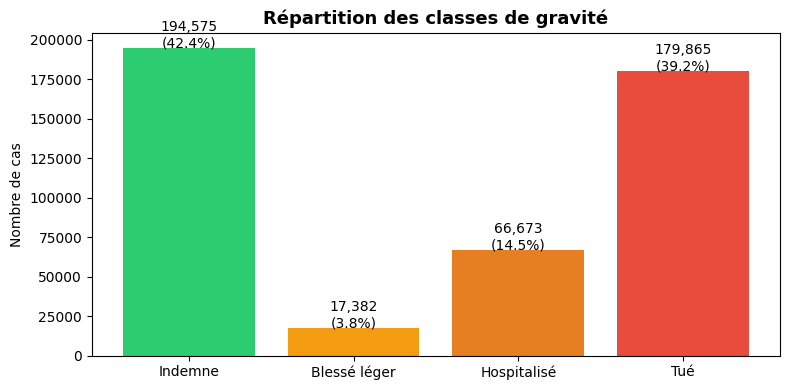

  Déséquilibre visible : classe 2 (Blessé léger) très sous-représentée


In [6]:
df_accidents_copy = df_accidents.copy()

# Visualisation de la répartition des classes
class_labels = {1: 'Indemne', 2: 'Blessé léger', 3: 'Hospitalisé', 4: 'Tué'}
class_counts = df_accidents_copy['grav'].value_counts().sort_index()

fig, ax = plt.subplots(figsize=(8, 4))
colors = ['#2ecc71', '#f39c12', '#e67e22', '#e74c3c']
bars = ax.bar(
    [class_labels[i] for i in class_counts.index],
    class_counts.values,
    color=colors
)
ax.set_title('Répartition des classes de gravité', fontsize=13, fontweight='bold')
ax.set_ylabel('Nombre de cas')
for bar, val in zip(bars, class_counts.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 500,
            f'{val:,}\n({val/len(df_accidents_copy)*100:.1f}%)',
            ha='center', fontsize=10)
plt.tight_layout()
plt.savefig('class_distribution.png', dpi=100)
plt.show()
print("  Déséquilibre visible : classe 2 (Blessé léger) très sous-représentée")

---
##  ÉTAPE 3 — Préparation des données

**Séparation X / y :**
- **X** = toutes les colonnes sauf `grav` → ce qu'on donne au modèle
- **y** = colonne `grav` → ce qu'on veut prédire

**Train / Test Split :**
- 80% des données pour apprendre
- 20% des données pour évaluer (données que le modèle n'a jamais vues)
- `stratify=y` : conserve les proportions des 4 classes dans chaque ensemble

**Standardisation :**  
Ramène toutes les colonnes à la même échelle (moyenne=0, écart-type=1).  
`fit_transform` sur le train, `transform` seulement sur le test (jamais recalculer sur le test).

In [7]:
# Séparation X / y
y = df_accidents_copy['grav']
X = df_accidents_copy.drop(columns=['grav'])

# Train / Test Split (80% / 20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Standardisation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Apprend ET applique
X_test_scaled  = scaler.transform(X_test)       # Applique seulement

print(f"Train : {X_train.shape[0]:,} lignes | Test : {X_test.shape[0]:,} lignes")
print(f"Features : {X.shape[1]} colonnes")
print(" Données prêtes")

Train : 366,796 lignes | Test : 91,699 lignes
Features : 26 colonnes
 Données prêtes


---
##  ÉTAPE 4 — Configuration des 4 modèles

Les 4 modèles sont tous des **classificateurs** : ils prédisent une catégorie parmi 4.

| Modèle | Principe | Analogie |
|--------|----------|----------|
| **LogisticRegression** | Calcul mathématique linéaire simple | Le mathématicien |
| **RandomForest** | Vote de 800 arbres de décision indépendants | Le jury populaire |
| **XGBoost** | Arbres qui apprennent des erreurs du précédent | L'élève perfectionniste |
| **LightGBM** | Même idée qu'XGBoost, optimisé pour la vitesse | L'élève perfectionniste rapide |

**Paramètres clés :**
- `n_estimators=800` : 800 arbres — plus d'arbres = meilleure précision mais plus lent
- `max_depth=30` : profondeur max des arbres — profond = capture plus de nuances
- `learning_rate=0.01` : vitesse d'apprentissage — lent = plus précis

In [8]:
# Configuration des 4 modèles avec les paramètres optimisés
model_configs = {
    "LogisticRegression": {
        "model": LogisticRegression,
        "params": {
            "max_iter": 1000,           # Nombre max d'itérations pour converger
            "class_weight": "balanced", # Compense le déséquilibre des classes
            "random_state": 42
        }
    },

    "RandomForest": {
        "model": RandomForestClassifier,
        "params": {
            "n_estimators": 800,               # 800 arbres de décision
            "max_depth": 30,                   # Profondeur max de chaque arbre
            "min_samples_split": 5,            # Min d'exemples pour diviser un nœud
            "min_samples_leaf": 2,             # Min d'exemples dans une feuille
            "max_features": "sqrt",            # Nb de features par split
            "class_weight": "balanced_subsample",
            "random_state": 42,
            "n_jobs": -1                       # Utilise tous les cœurs CPU
        }
    },

    "XGBoost": {
        "model": XGBClassifier,
        "params": {
            "n_estimators": 800,
            "max_depth": 30,
            "learning_rate": 0.01,             # Taux d'apprentissage
            "subsample": 0.8,                  # 80% des données par arbre
            "colsample_bytree": 0.8,           # 80% des colonnes par arbre
            "random_state": 42,
            "n_jobs": -1
        }
    },

    "LightGBM": {
        "model": LGBMClassifier,
        "params": {
            "n_estimators": 800,
            "max_depth": 30,
            "learning_rate": 0.01,
            "subsample": 0.8,
            "colsample_bytree": 0.8,
            "random_state": 42,
            "n_jobs": -1
        }
    }
}

print(f" {len(model_configs)} modèles configurés")

 4 modèles configurés


---
##  ÉTAPE 5 — Configuration MLflow

**`set_tracking_uri`** : indique à MLflow où stocker les données.  
Ici, dans un fichier SQLite local (`mlflow.db`) — pas besoin de serveur séparé sur Colab.

**`set_experiment`** : crée un dossier logique pour regrouper les runs.  
Tous les 4 modèles du Jour 1 iront dans l'expérience `crashseveritymodel`.

In [9]:
# Où MLflow stocke ses données (fichier local SQLite)
mlflow.set_tracking_uri("sqlite:///mlflow.db")

# Nom de l'expérience — regroupe tous les runs des 4 modèles
mlflow.set_experiment("crashseveritymodel")

print(" MLflow configuré")
print("   Tracking URI : sqlite:///mlflow.db")
print("   Expérience   : crashseveritymodel")

2026/02/26 15:47:50 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2026/02/26 15:47:50 INFO mlflow.store.db.utils: Updating database tables
2026/02/26 15:47:51 INFO mlflow.tracking.fluent: Experiment with name 'crashseveritymodel' does not exist. Creating a new experiment.


 MLflow configuré
   Tracking URI : sqlite:///mlflow.db
   Expérience   : crashseveritymodel


---
## ÉTAPE 6 — Entraînement des 4 modèles avec tracking MLflow

Pour chaque modèle, la boucle :
1. Ouvre un **run MLflow** (`with mlflow.start_run`)
2. Entraîne le modèle (`model.fit`)
3. Fait des prédictions (`model.predict`)
4. Calcule les métriques
5. Logue tout dans MLflow
6. Génère et logue la matrice de confusion comme artefact

**Pourquoi LabelEncoder pour XGBoost ?**  
XGBoost exige des classes numérotées de 0 à N-1.  
Notre variable `grav` va de 1 à 4 → LabelEncoder convertit [1,2,3,4] → [0,1,2,3] avant l'entraînement.

In [10]:
# Dictionnaire pour stocker les résultats et les afficher ensuite
results = {}

for model_name, config in model_configs.items():

    print(f"\n Entraînement de {model_name}...")

    # Ouverture d'un run MLflow — chaque modèle = une entrée dans le carnet
    with mlflow.start_run(run_name=model_name) as run:

        # Instanciation du modèle avec ses paramètres
        model = config["model"](**config["params"])

        # Logging des hyperparamètres AVANT l'entraînement
        mlflow.log_params(config["params"])

        # Cas particulier XGBoost : besoin de classes numérotées 0 à N-1
        if model_name == "XGBoost":
            le = LabelEncoder()
            y_train_enc = le.fit_transform(y_train)  # [1,2,3,4] → [0,1,2,3]
            model.fit(X_train_scaled, y_train_enc)
            y_pred = le.inverse_transform(model.predict(X_test_scaled))  # Retour [1,2,3,4]
        else:
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_test_scaled)

        # Calcul des métriques
        accuracy  = accuracy_score(y_test, y_pred)
        report    = classification_report(y_test, y_pred, output_dict=True)
        f1        = report["weighted avg"]["f1-score"]
        precision = report["weighted avg"]["precision"]
        recall    = report["weighted avg"]["recall"]

        # Logging des métriques dans MLflow
        mlflow.log_metric("accuracy",           accuracy)
        mlflow.log_metric("f1_weighted",        f1)
        mlflow.log_metric("precision_weighted", precision)
        mlflow.log_metric("recall_weighted",    recall)

        # Sauvegarde des résultats pour les graphiques
        results[model_name] = {
            "accuracy": accuracy, "f1": f1,
            "precision": precision, "recall": recall,
            "y_pred": y_pred, "model": model
        }

        # Génération et logging de la matrice de confusion
        cm = confusion_matrix(y_test, y_pred)
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.matshow(cm, cmap="Blues", alpha=0.6)
        for (i, j), val in np.ndenumerate(cm):
            ax.text(j, i, f'{val:,}', ha='center', va='center', color='red', fontsize=9)
        ax.set_title(f"Confusion Matrix - {model_name}\nAccuracy: {accuracy:.2%}")
        ax.set_xlabel('Prédit')
        ax.set_ylabel('Réel')
        ax.set_xticklabels(['', 'Indemne', 'Blessé léger', 'Hospitalisé', 'Tué'])
        ax.set_yticklabels(['', 'Indemne', 'Blessé léger', 'Hospitalisé', 'Tué'])
        cm_file = f"confusion_matrix_{model_name}.png"
        plt.savefig(cm_file, bbox_inches='tight')
        mlflow.log_artifact(cm_file)  # Envoi du fichier dans MLflow
        plt.close(fig)

        # Sauvegarde du modèle dans MLflow
        if model_name == "XGBoost":
            mlflow.xgboost.log_model(model, name=model_name + "_accidents_model")
            model_uri = f"runs:/{run.info.run_id}/XGBoost_accidents_model"
            mlflow.register_model(model_uri, "XGBoost_accidents_model")
        elif model_name == "LightGBM":
            mlflow.lightgbm.log_model(model, name=model_name + "_accidents_model")
        else:
            mlflow.sklearn.log_model(sk_model=model, name=model_name + "_accidents_model")

        mlflow.set_tag("model_type", model_name)

        print(f" {model_name} → Accuracy: {accuracy:.2%} | F1: {f1:.4f}")

print("\n Tous les modèles entraînés et loggés dans MLflow !")


 Entraînement de LogisticRegression...


/tmp/ipython-input-9394/3425158649.py:56: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['', 'Indemne', 'Blessé léger', 'Hospitalisé', 'Tué'])
/tmp/ipython-input-9394/3425158649.py:57: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['', 'Indemne', 'Blessé léger', 'Hospitalisé', 'Tué'])
2026/02/26 15:47:53 WARNING mlflow.sklearn: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization. The recommended safe alternative is the 'skops' format. For more information, see: https://scikit-learn.org/stable/model_persistence.html


 LogisticRegression → Accuracy: 44.70% | F1: 0.4677

 Entraînement de RandomForest...


/tmp/ipython-input-9394/3425158649.py:56: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['', 'Indemne', 'Blessé léger', 'Hospitalisé', 'Tué'])
/tmp/ipython-input-9394/3425158649.py:57: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['', 'Indemne', 'Blessé léger', 'Hospitalisé', 'Tué'])
2026/02/26 15:48:16 WARNING mlflow.sklearn: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization. The recommended safe alternative is the 'skops' format. For more information, see: https://scikit-learn.org/stable/model_persistence.html


 RandomForest → Accuracy: 66.14% | F1: 0.6594

 Entraînement de XGBoost...


/tmp/ipython-input-9394/3425158649.py:56: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['', 'Indemne', 'Blessé léger', 'Hospitalisé', 'Tué'])
/tmp/ipython-input-9394/3425158649.py:57: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['', 'Indemne', 'Blessé léger', 'Hospitalisé', 'Tué'])
Successfully registered model 'XGBoost_accidents_model'.
2026/02/26 15:55:28 WARNING mlflow.tracking._model_registry.fluent: Run with id 0a3151da2f3141318bd8851bf1f5fe23 has no artifacts at artifact path 'XGBoost_accidents_model', registering model based on models:/m-64adcbc43c7b406ba3b375518a75df04 instead
Created version '1' of model 'XGBoost_accidents_model'.


 XGBoost → Accuracy: 68.85% | F1: 0.6796

 Entraînement de LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006550 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 366796, number of used features: 26
[LightGBM] [Info] Start training from score -0.857132
[LightGBM] [Info] Start training from score -3.272485
[LightGBM] [Info] Start training from score -1.928157
[LightGBM] [Info] Start training from score -0.935743


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/tmp/ipython-input-9394/3425158649.py:56: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['', 'Indemne', 'Blessé léger', 'Hospitalisé', 'Tué'])
/tmp/ipython-input-9394/3425158649.py:57: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['', 'Indemne', 'Blessé léger', 'Hospitalisé', 'Tué'])


 LightGBM → Accuracy: 64.27% | F1: 0.6291

 Tous les modèles entraînés et loggés dans MLflow !


---
##  ÉTAPE 7 — Visualisation et comparaison des 4 modèles

Ces graphiques permettent de comparer visuellement les performances des modèles — exactement ce qu'on voit dans l'UI MLflow, mais directement dans le notebook.

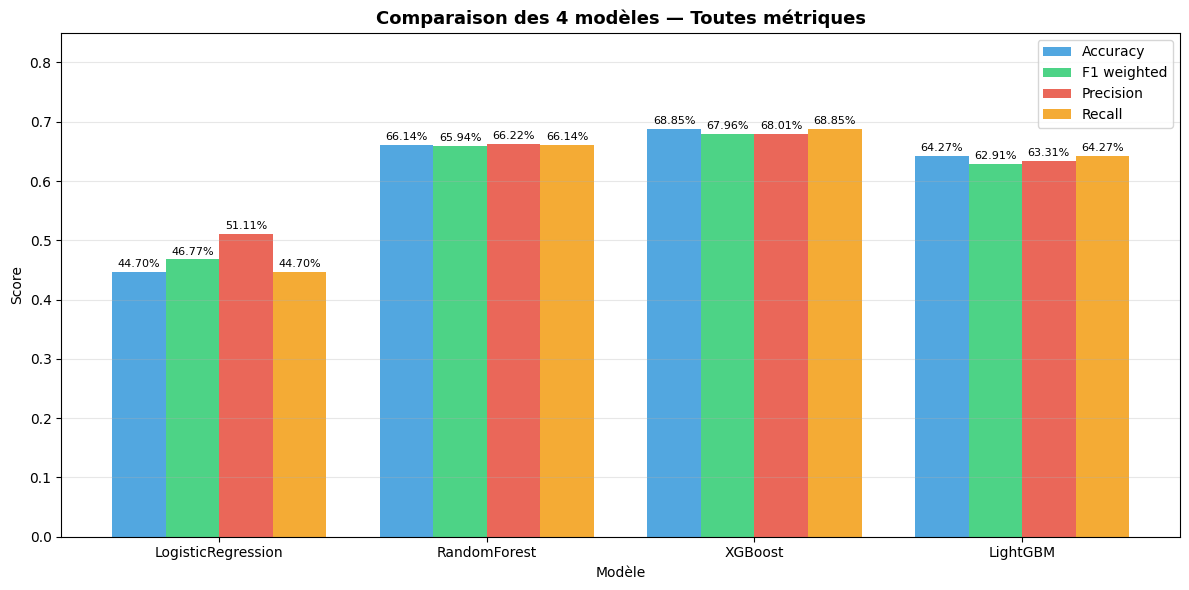

In [11]:
# ── Graphique 1 : Comparaison des métriques par modèle ────────────────────────
model_names  = list(results.keys())
accuracies   = [results[m]["accuracy"]  for m in model_names]
f1_scores    = [results[m]["f1"]        for m in model_names]
precisions   = [results[m]["precision"] for m in model_names]
recalls      = [results[m]["recall"]    for m in model_names]

x     = np.arange(len(model_names))
width = 0.2
colors_metrics = ['#3498db', '#2ecc71', '#e74c3c', '#f39c12']

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - 1.5*width, accuracies,  width, label='Accuracy',  color=colors_metrics[0], alpha=0.85)
bars2 = ax.bar(x - 0.5*width, f1_scores,   width, label='F1 weighted', color=colors_metrics[1], alpha=0.85)
bars3 = ax.bar(x + 0.5*width, precisions,  width, label='Precision', color=colors_metrics[2], alpha=0.85)
bars4 = ax.bar(x + 1.5*width, recalls,     width, label='Recall',    color=colors_metrics[3], alpha=0.85)

# Afficher les valeurs sur les barres
for bars in [bars1, bars2, bars3, bars4]:
    for bar in bars:
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                f'{bar.get_height():.2%}', ha='center', va='bottom', fontsize=8)

ax.set_xlabel('Modèle')
ax.set_ylabel('Score')
ax.set_title('Comparaison des 4 modèles — Toutes métriques', fontsize=13, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(model_names)
ax.set_ylim(0, 0.85)
ax.legend()
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('comparison_all_metrics.png', dpi=100, bbox_inches='tight')
plt.show()

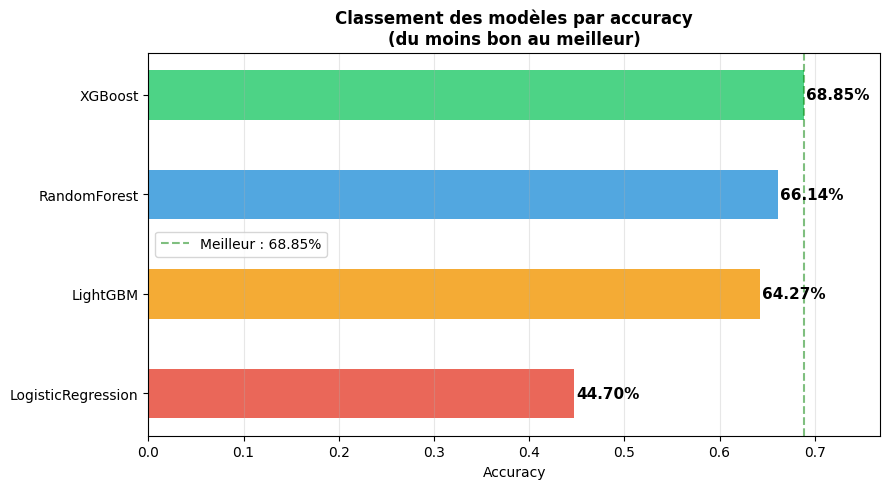

In [12]:
# ── Graphique 2 : Classement par accuracy (du plus faible au meilleur) ─────────
sorted_models = sorted(results.items(), key=lambda x: x[1]['accuracy'])
names_sorted  = [m for m, _ in sorted_models]
acc_sorted    = [r['accuracy'] for _, r in sorted_models]
colors_rank   = ['#e74c3c', '#f39c12', '#3498db', '#2ecc71']

fig, ax = plt.subplots(figsize=(9, 5))
bars = ax.barh(names_sorted, acc_sorted, color=colors_rank, alpha=0.85, height=0.5)

for bar, val in zip(bars, acc_sorted):
    ax.text(val + 0.002, bar.get_y() + bar.get_height()/2,
            f'{val:.2%}', va='center', fontsize=11, fontweight='bold')

ax.set_xlabel('Accuracy')
ax.set_title('Classement des modèles par accuracy\n(du moins bon au meilleur)', fontsize=12, fontweight='bold')
ax.set_xlim(0, max(acc_sorted) + 0.08)
ax.axvline(x=max(acc_sorted), color='green', linestyle='--', alpha=0.5, label=f'Meilleur : {max(acc_sorted):.2%}')
ax.legend()
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('model_ranking.png', dpi=100, bbox_inches='tight')
plt.show()

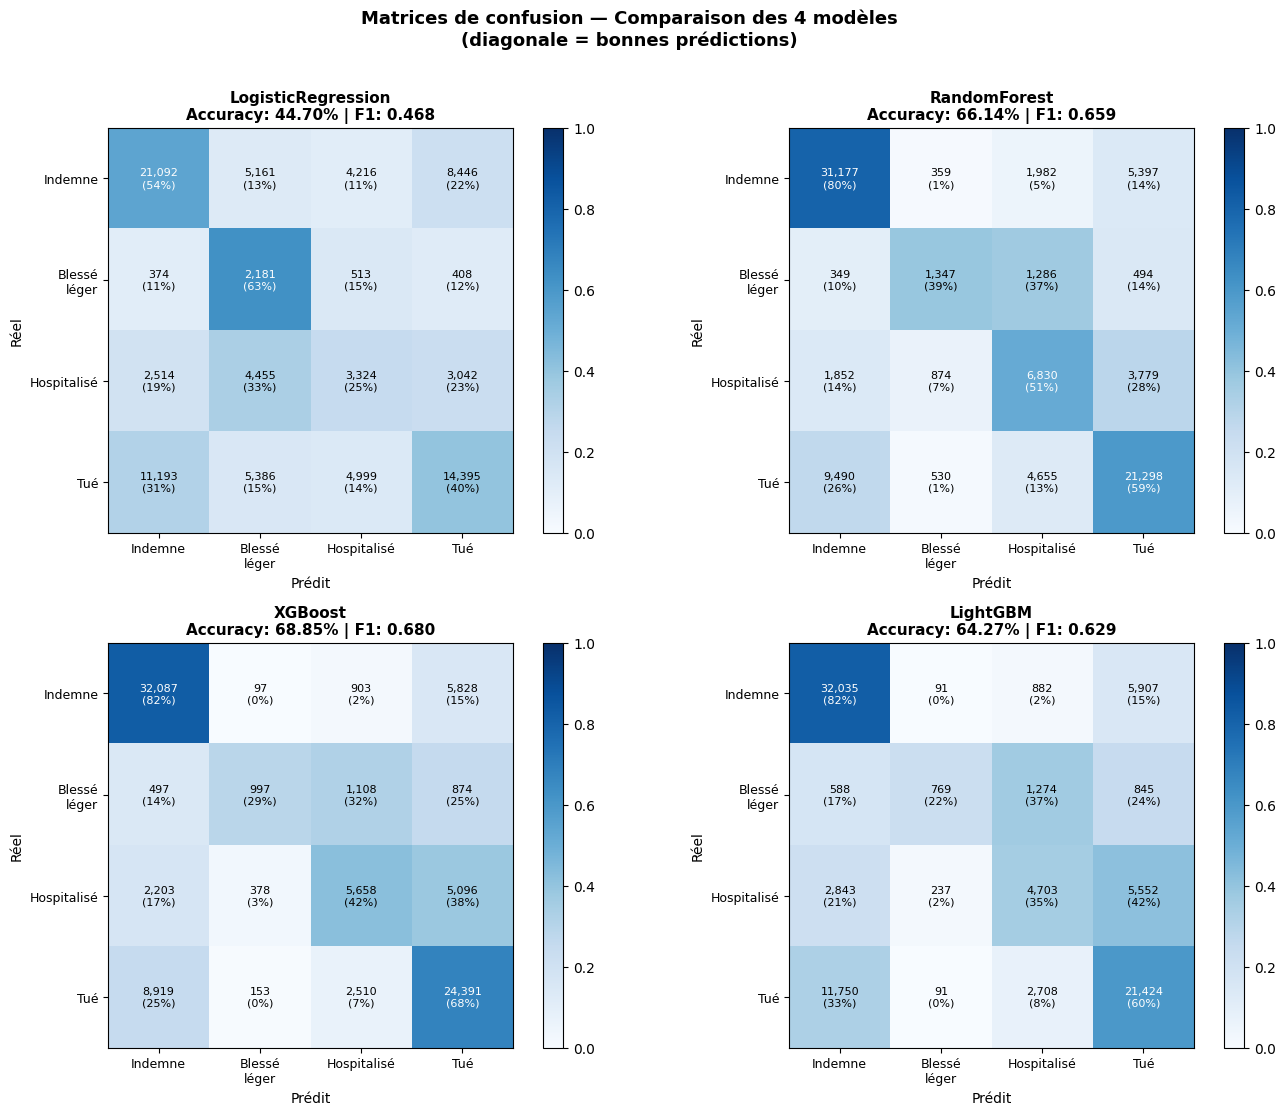

  La classe 2 (Blessé léger) est la plus difficile à prédire pour tous les modèles


In [13]:
# ── Graphique 3 : 4 matrices de confusion côte à côte ─────────────────────────
class_labels_short = ['Indemne', 'Blessé\nléger', 'Hospitalisé', 'Tué']

fig, axes = plt.subplots(2, 2, figsize=(14, 11))
axes = axes.flatten()

for i, (model_name, res) in enumerate(results.items()):
    cm = confusion_matrix(y_test, res['y_pred'])

    # Normalisation pour voir les pourcentages
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    im = axes[i].imshow(cm_norm, interpolation='nearest', cmap='Blues', vmin=0, vmax=1)

    # Afficher valeurs absolutes ET pourcentages
    for row in range(cm.shape[0]):
        for col in range(cm.shape[1]):
            color = 'white' if cm_norm[row, col] > 0.5 else 'black'
            axes[i].text(col, row,
                        f'{cm[row, col]:,}\n({cm_norm[row, col]:.0%})',
                        ha='center', va='center', color=color, fontsize=8)

    axes[i].set_xticks(range(4))
    axes[i].set_yticks(range(4))
    axes[i].set_xticklabels(class_labels_short, fontsize=9)
    axes[i].set_yticklabels(class_labels_short, fontsize=9)
    axes[i].set_xlabel('Prédit', fontsize=10)
    axes[i].set_ylabel('Réel',   fontsize=10)
    axes[i].set_title(
        f'{model_name}\nAccuracy: {res["accuracy"]:.2%} | F1: {res["f1"]:.3f}',
        fontsize=11, fontweight='bold'
    )
    plt.colorbar(im, ax=axes[i])

plt.suptitle('Matrices de confusion — Comparaison des 4 modèles\n(diagonale = bonnes prédictions)',
             fontsize=13, fontweight='bold', y=1.01)
plt.tight_layout()
plt.savefig('confusion_matrices_all.png', dpi=100, bbox_inches='tight')
plt.show()
print("  La classe 2 (Blessé léger) est la plus difficile à prédire pour tous les modèles")

---
## ÉTAPE 8 — Tuning manuel de LightGBM

LightGBM est le meilleur modèle. On va tester 3 configurations de paramètres choisies manuellement.

**Tuning manuel** = on choisit nous-mêmes les combinaisons à tester, en s'appuyant sur notre intuition.  
Chaque configuration = **1 run MLflow séparé** dans une expérience dédiée `tuning-lightgbm`.  
Pourquoi une expérience séparée ? Pour ne pas mélanger les runs de comparaison avec les runs de tuning.

In [14]:
mlflow.set_experiment("tuning-lightgbm")

tuning_configs = [
    {"n_estimators": 200, "max_depth": 8,  "learning_rate": 0.05},  # Rapide
    {"n_estimators": 300, "max_depth": 10, "learning_rate": 0.03},  # Équilibrée
    {"n_estimators": 500, "max_depth": 12, "learning_rate": 0.01},  # Profonde
]

tuning_results = []

for i, params in enumerate(tuning_configs):
    with mlflow.start_run(run_name=f"LightGBM-config-{i+1}"):
        full_params = {**params, "subsample": 0.8, "colsample_bytree": 0.8,
                       "random_state": 42, "n_jobs": -1}

        model_lgbm = LGBMClassifier(**full_params)
        model_lgbm.fit(X_train_scaled, y_train)
        y_pred = model_lgbm.predict(X_test_scaled)

        report = classification_report(y_test, y_pred, output_dict=True)
        acc = accuracy_score(y_test, y_pred)
        f1  = report["weighted avg"]["f1-score"]

        mlflow.log_params(full_params)
        mlflow.log_metric("accuracy",    acc)
        mlflow.log_metric("f1_weighted", f1)

        tuning_results.append({"config": f"Config {i+1}", "accuracy": acc, "f1": f1, **params})
        print(f"Config {i+1} → Accuracy: {acc:.4f} | F1: {f1:.4f}")

2026/02/26 15:55:47 INFO mlflow.tracking.fluent: Experiment with name 'tuning-lightgbm' does not exist. Creating a new experiment.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005461 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 366796, number of used features: 26
[LightGBM] [Info] Start training from score -0.857132
[LightGBM] [Info] Start training from score -3.272485
[LightGBM] [Info] Start training from score -1.928157
[LightGBM] [Info] Start training from score -0.935743


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Config 1 → Accuracy: 0.6431 | F1: 0.6298
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006562 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 366796, number of used features: 26
[LightGBM] [Info] Start training from score -0.857132
[LightGBM] [Info] Start training from score -3.272485
[LightGBM] [Info] Start training from score -1.928157
[LightGBM] [Info] Start training from score -0.935743


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Config 2 → Accuracy: 0.6426 | F1: 0.6291
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005674 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 366796, number of used features: 26
[LightGBM] [Info] Start training from score -0.857132
[LightGBM] [Info] Start training from score -3.272485
[LightGBM] [Info] Start training from score -1.928157
[LightGBM] [Info] Start training from score -0.935743


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Config 3 → Accuracy: 0.6401 | F1: 0.6254


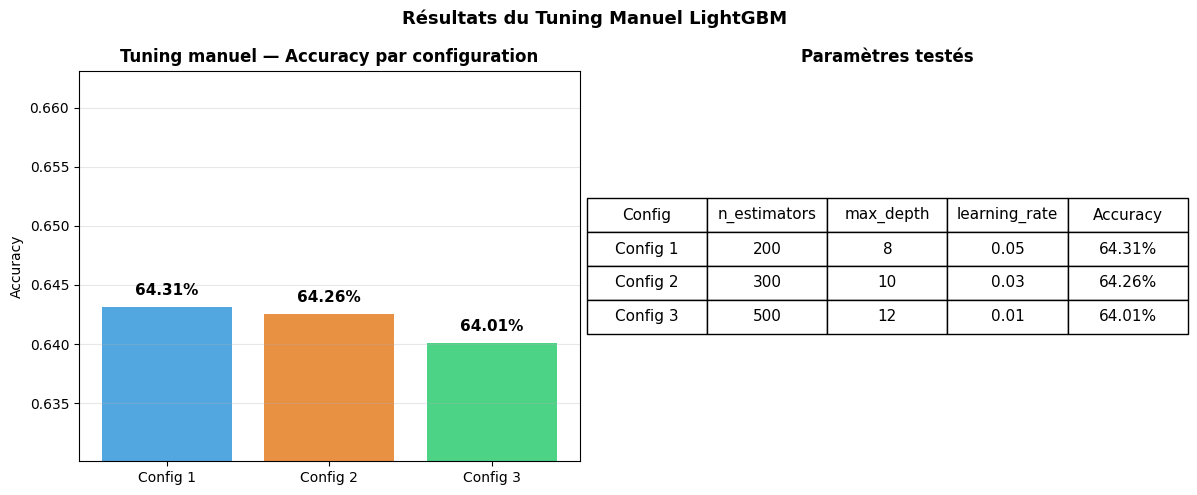

In [15]:
# ── Graphique 4 : Résultats du tuning manuel ───────────────────────────────────
df_tuning = pd.DataFrame(tuning_results)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Graphique accuracy
colors_tuning = ['#3498db', '#e67e22', '#2ecc71']
bars = axes[0].bar(df_tuning['config'], df_tuning['accuracy'],
                   color=colors_tuning, alpha=0.85)
for bar, val in zip(bars, df_tuning['accuracy']):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
                f'{val:.2%}', ha='center', fontsize=11, fontweight='bold')
axes[0].set_title('Tuning manuel — Accuracy par configuration', fontweight='bold')
axes[0].set_ylabel('Accuracy')
axes[0].set_ylim(min(df_tuning['accuracy']) - 0.01, max(df_tuning['accuracy']) + 0.02)
axes[0].grid(axis='y', alpha=0.3)

# Tableau récapitulatif
axes[1].axis('off')
table_data = []
for _, row in df_tuning.iterrows():
    table_data.append([
        row['config'],
        str(int(row['n_estimators'])),
        str(int(row['max_depth'])),
        str(row['learning_rate']),
        f"{row['accuracy']:.2%}"
    ])
table = axes[1].table(
    cellText=table_data,
    colLabels=['Config', 'n_estimators', 'max_depth', 'learning_rate', 'Accuracy'],
    loc='center', cellLoc='center'
)
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1.2, 2)
axes[1].set_title('Paramètres testés', fontweight='bold')

plt.suptitle('Résultats du Tuning Manuel LightGBM', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('tuning_manual_results.png', dpi=100, bbox_inches='tight')
plt.show()

---
##  ÉTAPE 9 — Artefacts supplémentaires du meilleur modèle

On logue des artefacts supplémentaires sur la meilleure configuration :
1. **Matrice de confusion** (PNG)
2. **Feature names** (TXT) — liste des colonnes utilisées
3. **Métadonnées du dataset** — taille, split train/test

In [16]:
mlflow.set_experiment("tuning-lightgbm")

best_params = {"n_estimators": 200, "max_depth": 8, "learning_rate": 0.05,
               "subsample": 0.8, "colsample_bytree": 0.8, "random_state": 42, "n_jobs": -1}

with mlflow.start_run(run_name="LightGBM-best-artefacts"):
    model_best = LGBMClassifier(**best_params)
    model_best.fit(X_train_scaled, y_train)
    y_pred_best = model_best.predict(X_test_scaled)

    report = classification_report(y_test, y_pred_best, output_dict=True)
    mlflow.log_params(best_params)
    mlflow.log_metric("accuracy",    accuracy_score(y_test, y_pred_best))
    mlflow.log_metric("f1_weighted", report["weighted avg"]["f1-score"])

    # Artefact 1 : Confusion Matrix
    cm = confusion_matrix(y_test, y_pred_best)
    fig, ax = plt.subplots(figsize=(6, 6))
    ConfusionMatrixDisplay(cm).plot(ax=ax, cmap="Blues")
    ax.set_title("Confusion Matrix — LightGBM Best")
    plt.savefig("confusion_matrix_best.png")
    mlflow.log_artifact("confusion_matrix_best.png")  # Envoi dans MLflow
    plt.close()

    # Artefact 2 : Feature names
    with open("feature_names.txt", "w") as f:
        f.write("\n".join(list(X.columns)))
    mlflow.log_artifact("feature_names.txt")  # Envoi dans MLflow

    # Artefact 3 : Métadonnées dataset
    mlflow.log_param("dataset_rows", len(df_accidents))
    mlflow.log_param("dataset_cols", X.shape[1])
    mlflow.log_param("train_size",   len(X_train))
    mlflow.log_param("test_size",    len(X_test))

    print(f"✅ Accuracy : {accuracy_score(y_test, y_pred_best):.4f}")
    print("✅ Artefacts loggés : confusion matrix, feature names, métadonnées")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006574 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 366796, number of used features: 26
[LightGBM] [Info] Start training from score -0.857132
[LightGBM] [Info] Start training from score -3.272485
[LightGBM] [Info] Start training from score -1.928157
[LightGBM] [Info] Start training from score -0.935743


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


✅ Accuracy : 0.6431
✅ Artefacts loggés : confusion matrix, feature names, métadonnées


---
##  ÉTAPE 10 — Model Registry

Le **Model Registry** est l'entrepôt versionné de MLflow. Le modèle XGBoost a été enregistré lors de la boucle d'entraînement.

On peut le recharger directement pour faire des prédictions — sans réentraîner.

In [17]:
# Rechargement du modèle XGBoost depuis le Model Registry
model_name_reg = "XGBoost_accidents_model"
model_uri      = f"models:/{model_name_reg}/latest"  # 'latest' = dernière version

loaded_model = mlflow.pyfunc.load_model(model_uri)
predictions  = loaded_model.predict(X_test_scaled)

print("Modèle rechargé depuis le Registry")
print(f"5 premières prédictions : {predictions[:5]}")
print("1=Indemne | 2=Blessé léger | 3=Hospitalisé | 4=Tué")

Modèle rechargé depuis le Registry
5 premières prédictions : [3 0 0 0 0]
1=Indemne | 2=Blessé léger | 3=Hospitalisé | 4=Tué


---
## ÉTAPE 11 — GridSearchCV + MLflow

**GridSearchCV** teste automatiquement **toutes les combinaisons** d'une grille de paramètres.

Exemple : 2 valeurs × 2 valeurs × 2 valeurs = **8 combinaisons** testées automatiquement.

**cv=3** = cross-validation à 3 folds : chaque combinaison est testée 3 fois sur des portions différentes. Total : 8 × 3 = **24 entraînements**.

**Avantage** : exhaustif, ne rate aucune combinaison.  
**Inconvénient** : lent si la grille est grande.

In [18]:
mlflow.set_experiment("gridsearch-lightgbm")

# Grille des paramètres à tester — toutes les combinaisons seront testées
param_grid = {
    "n_estimators":  [100, 200],   # 2 valeurs
    "max_depth":     [6, 8],       # 2 valeurs
    "learning_rate": [0.05, 0.01]  # 2 valeurs → 8 combinaisons
}

base_model = LGBMClassifier(subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1)

grid_search = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    cv=3,              # 3-fold cross-validation
    scoring="accuracy",
    verbose=1
)
grid_search.fit(X_train_scaled, y_train)

# Logger chaque combinaison comme un run MLflow séparé
gridsearch_results = []
for i in range(len(grid_search.cv_results_["params"])):
    with mlflow.start_run(run_name=f"GridSearch-combo-{i+1}"):
        mlflow.log_params(grid_search.cv_results_["params"][i])
        score = grid_search.cv_results_["mean_test_score"][i]
        mlflow.log_metric("mean_cv_accuracy", score)
        gridsearch_results.append({**grid_search.cv_results_["params"][i], "score": score})

print(f"\n GridSearch terminé")
print(f"Meilleurs paramètres : {grid_search.best_params_}")
print(f"Meilleure accuracy   : {grid_search.best_score_:.4f}")

2026/02/26 15:56:15 INFO mlflow.tracking.fluent: Experiment with name 'gridsearch-lightgbm' does not exist. Creating a new experiment.


Fitting 3 folds for each of 8 candidates, totalling 24 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004073 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 244530, number of used features: 26
[LightGBM] [Info] Start training from score -0.857123
[LightGBM] [Info] Start training from score -3.272555
[LightGBM] [Info] Start training from score -1.928173
[LightGBM] [Info] Start training from score -0.935740


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004206 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 291
[LightGBM] [Info] Number of data points in the train set: 244531, number of used features: 26
[LightGBM] [Info] Start training from score -0.857136
[LightGBM] [Info] Start training from score -3.272451
[LightGBM] [Info] Start training from score -1.928149
[LightGBM] [Info] Start training from score -0.935744


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004607 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 291
[LightGBM] [Info] Number of data points in the train set: 244531, number of used features: 26
[LightGBM] [Info] Start training from score -0.857136
[LightGBM] [Info] Start training from score -3.272451
[LightGBM] [Info] Start training from score -1.928149
[LightGBM] [Info] Start training from score -0.935744


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004032 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 244530, number of used features: 26
[LightGBM] [Info] Start training from score -0.857123
[LightGBM] [Info] Start training from score -3.272555
[LightGBM] [Info] Start training from score -1.928173
[LightGBM] [Info] Start training from score -0.935740
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004231 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 291
[LightGBM] [Info] Number of data points in the train set: 244531, number of used features: 26
[LightGBM] [Info] Start training from score -0.857136
[LightGBM] [Info] Start training from score -3.272451
[LightGBM] [Info] Start training from score -1.928149
[LightGBM] [Info] Start training from score -0.935744
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004407 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 291
[LightGBM] [Info] Number of data points in the train set: 244531, number of used features: 26
[LightGBM] [Info] Start training from score -0.857136
[LightGBM] [Info] Start training from score -3.272451
[LightGBM] [Info] Start training from score -1.928149
[LightGBM] [Info] Start training from score -0.935744
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003593 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 244530, number of used features: 26
[LightGBM] [Info] Start training from score -0.857123
[LightGBM] [Info] Start training from score -3.272555
[LightGBM] [Info] Start training from score -1.928173
[LightGBM] [Info] Start training from score -0.935740


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005208 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 291
[LightGBM] [Info] Number of data points in the train set: 244531, number of used features: 26
[LightGBM] [Info] Start training from score -0.857136
[LightGBM] [Info] Start training from score -3.272451
[LightGBM] [Info] Start training from score -1.928149
[LightGBM] [Info] Start training from score -0.935744


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004215 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 291
[LightGBM] [Info] Number of data points in the train set: 244531, number of used features: 26
[LightGBM] [Info] Start training from score -0.857136
[LightGBM] [Info] Start training from score -3.272451
[LightGBM] [Info] Start training from score -1.928149
[LightGBM] [Info] Start training from score -0.935744


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004297 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 244530, number of used features: 26
[LightGBM] [Info] Start training from score -0.857123
[LightGBM] [Info] Start training from score -3.272555
[LightGBM] [Info] Start training from score -1.928173
[LightGBM] [Info] Start training from score -0.935740


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004171 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 291
[LightGBM] [Info] Number of data points in the train set: 244531, number of used features: 26
[LightGBM] [Info] Start training from score -0.857136
[LightGBM] [Info] Start training from score -3.272451
[LightGBM] [Info] Start training from score -1.928149
[LightGBM] [Info] Start training from score -0.935744


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004660 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 291
[LightGBM] [Info] Number of data points in the train set: 244531, number of used features: 26
[LightGBM] [Info] Start training from score -0.857136
[LightGBM] [Info] Start training from score -3.272451
[LightGBM] [Info] Start training from score -1.928149
[LightGBM] [Info] Start training from score -0.935744


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004549 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 244530, number of used features: 26
[LightGBM] [Info] Start training from score -0.857123
[LightGBM] [Info] Start training from score -3.272555
[LightGBM] [Info] Start training from score -1.928173
[LightGBM] [Info] Start training from score -0.935740


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004237 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 291
[LightGBM] [Info] Number of data points in the train set: 244531, number of used features: 26
[LightGBM] [Info] Start training from score -0.857136
[LightGBM] [Info] Start training from score -3.272451
[LightGBM] [Info] Start training from score -1.928149
[LightGBM] [Info] Start training from score -0.935744


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004591 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 291
[LightGBM] [Info] Number of data points in the train set: 244531, number of used features: 26
[LightGBM] [Info] Start training from score -0.857136
[LightGBM] [Info] Start training from score -3.272451
[LightGBM] [Info] Start training from score -1.928149
[LightGBM] [Info] Start training from score -0.935744


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004117 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 244530, number of used features: 26
[LightGBM] [Info] Start training from score -0.857123
[LightGBM] [Info] Start training from score -3.272555
[LightGBM] [Info] Start training from score -1.928173
[LightGBM] [Info] Start training from score -0.935740


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004136 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 291
[LightGBM] [Info] Number of data points in the train set: 244531, number of used features: 26
[LightGBM] [Info] Start training from score -0.857136
[LightGBM] [Info] Start training from score -3.272451
[LightGBM] [Info] Start training from score -1.928149
[LightGBM] [Info] Start training from score -0.935744


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005826 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 291
[LightGBM] [Info] Number of data points in the train set: 244531, number of used features: 26
[LightGBM] [Info] Start training from score -0.857136
[LightGBM] [Info] Start training from score -3.272451
[LightGBM] [Info] Start training from score -1.928149
[LightGBM] [Info] Start training from score -0.935744


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004126 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 244530, number of used features: 26
[LightGBM] [Info] Start training from score -0.857123
[LightGBM] [Info] Start training from score -3.272555
[LightGBM] [Info] Start training from score -1.928173
[LightGBM] [Info] Start training from score -0.935740


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007808 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 291
[LightGBM] [Info] Number of data points in the train set: 244531, number of used features: 26
[LightGBM] [Info] Start training from score -0.857136
[LightGBM] [Info] Start training from score -3.272451
[LightGBM] [Info] Start training from score -1.928149
[LightGBM] [Info] Start training from score -0.935744


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004023 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 291
[LightGBM] [Info] Number of data points in the train set: 244531, number of used features: 26
[LightGBM] [Info] Start training from score -0.857136
[LightGBM] [Info] Start training from score -3.272451
[LightGBM] [Info] Start training from score -1.928149
[LightGBM] [Info] Start training from score -0.935744


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003985 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 244530, number of used features: 26
[LightGBM] [Info] Start training from score -0.857123
[LightGBM] [Info] Start training from score -3.272555
[LightGBM] [Info] Start training from score -1.928173
[LightGBM] [Info] Start training from score -0.935740


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004669 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 291
[LightGBM] [Info] Number of data points in the train set: 244531, number of used features: 26
[LightGBM] [Info] Start training from score -0.857136
[LightGBM] [Info] Start training from score -3.272451
[LightGBM] [Info] Start training from score -1.928149
[LightGBM] [Info] Start training from score -0.935744


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003913 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 291
[LightGBM] [Info] Number of data points in the train set: 244531, number of used features: 26
[LightGBM] [Info] Start training from score -0.857136
[LightGBM] [Info] Start training from score -3.272451
[LightGBM] [Info] Start training from score -1.928149
[LightGBM] [Info] Start training from score -0.935744


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006653 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 366796, number of used features: 26
[LightGBM] [Info] Start training from score -0.857132
[LightGBM] [Info] Start training from score -3.272485
[LightGBM] [Info] Start training from score -1.928157
[LightGBM] [Info] Start training from score -0.935743

 GridSearch terminé
Meilleurs paramètres : {'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 200}
Meilleure accuracy   : 0.6430


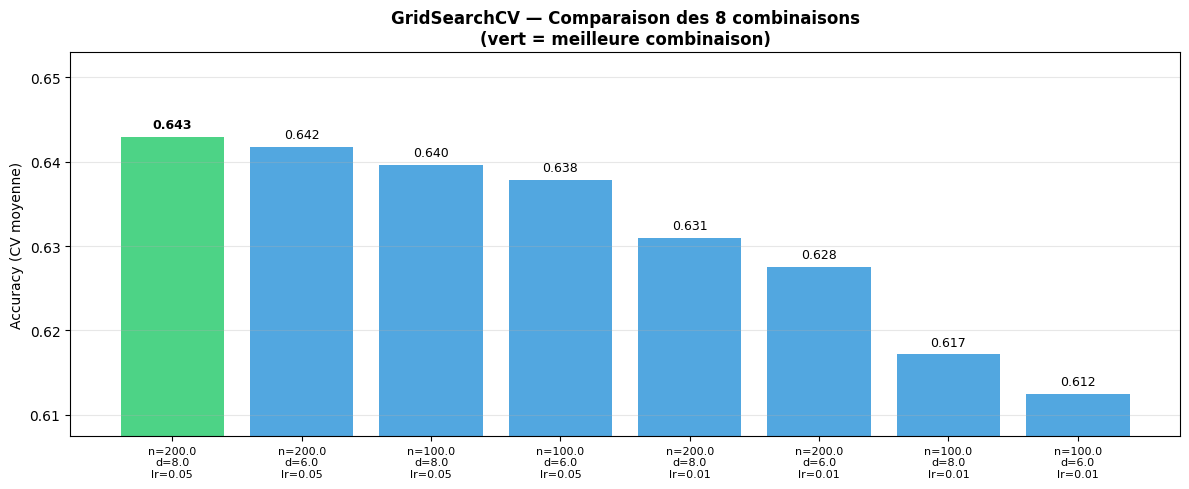

In [19]:
# ── Graphique 5 : Résultats GridSearch ────────────────────────────────────────
df_gs = pd.DataFrame(gridsearch_results).sort_values('score', ascending=False)

fig, ax = plt.subplots(figsize=(12, 5))
labels  = [f"n={r['n_estimators']}\nd={r['max_depth']}\nlr={r['learning_rate']}" for _, r in df_gs.iterrows()]
colors_gs = ['#2ecc71' if i == 0 else '#3498db' for i in range(len(df_gs))]
bars = ax.bar(range(len(df_gs)), df_gs['score'], color=colors_gs, alpha=0.85)

for i, (bar, val) in enumerate(zip(bars, df_gs['score'])):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
            f'{val:.3f}', ha='center', fontsize=9, fontweight='bold' if i == 0 else 'normal')

ax.set_xticks(range(len(df_gs)))
ax.set_xticklabels(labels, fontsize=8)
ax.set_ylabel('Accuracy (CV moyenne)')
ax.set_title('GridSearchCV — Comparaison des 8 combinaisons\n(vert = meilleure combinaison)',
             fontsize=12, fontweight='bold')
ax.set_ylim(min(df_gs['score']) - 0.005, max(df_gs['score']) + 0.01)
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('gridsearch_results.png', dpi=100, bbox_inches='tight')
plt.show()

---
##  ÉTAPE 12 — Optuna + MLflow

**Optuna** utilise l'**optimisation bayésienne** : il apprend de chaque essai pour cibler les prochains paramètres les plus prometteurs. Avec seulement 10 essais, il trouve souvent mieux que GridSearch avec 24 essais.

**Analogie** : au lieu de goûter les 500 cafés de Lyon dans l'ordre, Optuna goûte 5 cafés, apprend ce qu'on aime, et cible intelligemment les suivants.

**`trial.suggest_int / suggest_float`** : Optuna choisit intelligemment une valeur dans la plage indiquée.

In [20]:
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

mlflow.set_experiment("optuna-lightgbm")

optuna_results = []

def objective(trial):
    # Optuna choisit intelligemment les valeurs dans ces plages
    params = {
        "n_estimators":     trial.suggest_int(  "n_estimators",  100, 500),
        "max_depth":        trial.suggest_int(  "max_depth",     4,   12),
        "learning_rate":    trial.suggest_float("learning_rate", 0.01, 0.1),
        "subsample":        0.8,
        "colsample_bytree": 0.8,
        "random_state":     42,
        "n_jobs":           -1
    }

    # Chaque essai Optuna = 1 run MLflow
    with mlflow.start_run(run_name=f"Optuna-trial-{trial.number}"):
        model_opt = LGBMClassifier(**params)
        model_opt.fit(X_train_scaled, y_train)
        y_pred = model_opt.predict(X_test_scaled)
        acc = accuracy_score(y_test, y_pred)

        mlflow.log_params(params)
        mlflow.log_metric("accuracy", acc)

        optuna_results.append({"trial": trial.number, "accuracy": acc, **params})

    return acc  # Optuna utilise ce score pour orienter le prochain essai

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

print(f"\n Optuna terminé — 10 essais intelligents")
print(f"Meilleurs paramètres : {study.best_params}")
print(f"Meilleure accuracy   : {study.best_value:.4f}")

2026/02/26 15:57:12 INFO mlflow.tracking.fluent: Experiment with name 'optuna-lightgbm' does not exist. Creating a new experiment.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017880 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 366796, number of used features: 26
[LightGBM] [Info] Start training from score -0.857132
[LightGBM] [Info] Start training from score -3.272485
[LightGBM] [Info] Start training from score -1.928157
[LightGBM] [Info] Start training from score -0.935743
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006480 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 366796, number of used features: 26
[LightGBM] [Info] Start training from score -0.857132
[LightGBM] [Info] Start training from score -3.272485
[LightGBM] [Info] Start training from score -1.928157
[LightGBM] [Info] Start training from score -0.935743
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006598 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 366796, number of used features: 26
[LightGBM] [Info] Start training from score -0.857132
[LightGBM] [Info] Start training from score -3.272485
[LightGBM] [Info] Start training from score -1.928157
[LightGBM] [Info] Start training from score -0.935743
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006458 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 366796, number of used features: 26
[LightGBM] [Info] Start training from score -0.857132
[LightGBM] [Info] Start training from score -3.272485
[LightGBM] [Info] Start training from score -1.928157
[LightGBM] [Info] Start training from score -0.935743


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006288 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 366796, number of used features: 26
[LightGBM] [Info] Start training from score -0.857132
[LightGBM] [Info] Start training from score -3.272485
[LightGBM] [Info] Start training from score -1.928157
[LightGBM] [Info] Start training from score -0.935743


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006551 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 366796, number of used features: 26
[LightGBM] [Info] Start training from score -0.857132
[LightGBM] [Info] Start training from score -3.272485
[LightGBM] [Info] Start training from score -1.928157
[LightGBM] [Info] Start training from score -0.935743


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006664 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 366796, number of used features: 26
[LightGBM] [Info] Start training from score -0.857132
[LightGBM] [Info] Start training from score -3.272485
[LightGBM] [Info] Start training from score -1.928157
[LightGBM] [Info] Start training from score -0.935743
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006548 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 366796, number of used features: 26
[LightGBM] [Info] Start training from score -0.857132
[LightGBM] [Info] Start training from score -3.272485
[LightGBM] [Info] Start training from score -1.928157
[LightGBM] [Info] Start training from score -0.935743


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006669 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 366796, number of used features: 26
[LightGBM] [Info] Start training from score -0.857132
[LightGBM] [Info] Start training from score -3.272485
[LightGBM] [Info] Start training from score -1.928157
[LightGBM] [Info] Start training from score -0.935743


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005990 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 366796, number of used features: 26
[LightGBM] [Info] Start training from score -0.857132
[LightGBM] [Info] Start training from score -3.272485
[LightGBM] [Info] Start training from score -1.928157
[LightGBM] [Info] Start training from score -0.935743


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



 Optuna terminé — 10 essais intelligents
Meilleurs paramètres : {'n_estimators': 417, 'max_depth': 9, 'learning_rate': 0.03661914431741803}
Meilleure accuracy   : 0.6451


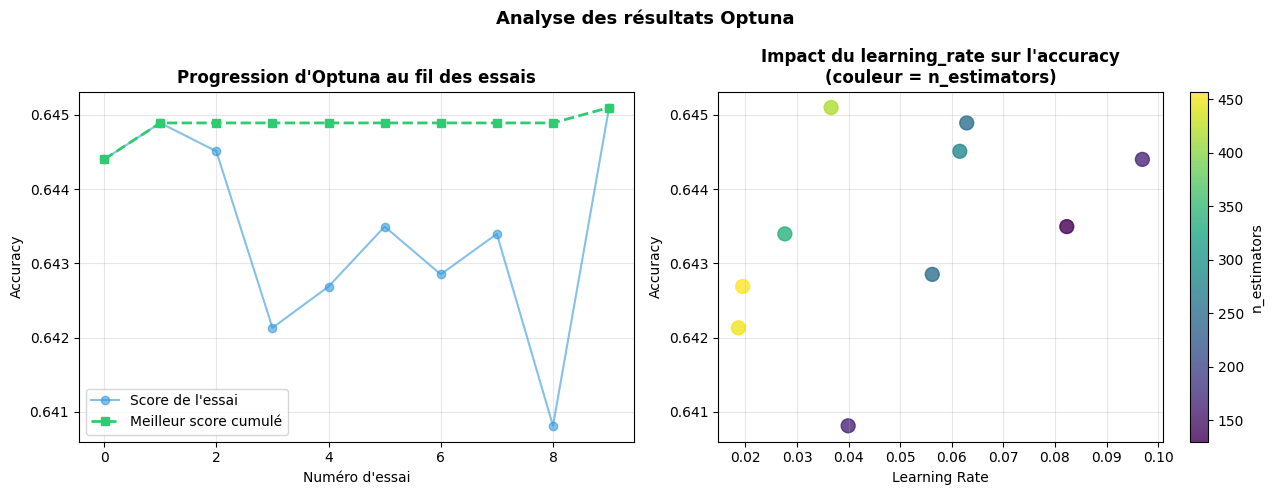

In [21]:
# ── Graphique 6 : Progression d'Optuna (apprentissage au fil des essais) ───────
df_optuna = pd.DataFrame(optuna_results)
best_so_far = df_optuna['accuracy'].cummax()  # Meilleur score à chaque essai

fig, axes = plt.subplots(1, 2, figsize=(13, 5))

# Progression du meilleur score
axes[0].plot(df_optuna['trial'], df_optuna['accuracy'],
             'o-', color='#3498db', alpha=0.6, label='Score de l\'essai')
axes[0].plot(df_optuna['trial'], best_so_far,
             's--', color='#2ecc71', linewidth=2, label='Meilleur score cumulé')
axes[0].set_xlabel('Numéro d\'essai')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Progression d\'Optuna au fil des essais', fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Relation learning_rate vs accuracy
scatter = axes[1].scatter(
    df_optuna['learning_rate'], df_optuna['accuracy'],
    c=df_optuna['n_estimators'], cmap='viridis', s=100, alpha=0.8
)
plt.colorbar(scatter, ax=axes[1], label='n_estimators')
axes[1].set_xlabel('Learning Rate')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Impact du learning_rate sur l\'accuracy\n(couleur = n_estimators)', fontweight='bold')
axes[1].grid(alpha=0.3)

plt.suptitle('Analyse des résultats Optuna', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('optuna_results.png', dpi=100, bbox_inches='tight')
plt.show()

---
## ÉTAPE 13 — Bilan final et comparaison des 3 méthodes

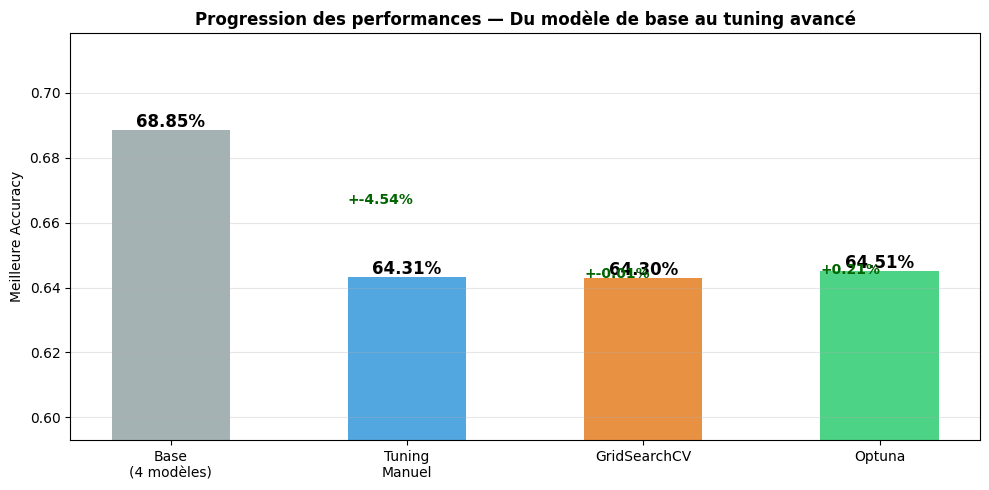


BILAN FINAL
Méthode              Meilleure accuracy   Nb essais
-------------------------------------------------------
Base (LightGBM)      68.85%               1
Tuning manuel        64.31%               3 (choisis à la main)
GridSearchCV         64.30%               8 (grille complète)
Optuna               64.51%               10 (intelligents)

→ Optuna trouve le meilleur résultat avec le moins d'essais
→ Problème principal : déséquilibre de la classe 2 (Blessé léger)


In [22]:
# ── Graphique 7 : Comparaison des 3 méthodes de tuning ────────────────────────
best_base     = max(results[m]['accuracy'] for m in results)
best_manual   = max(r['accuracy'] for r in tuning_results)
best_grid     = grid_search.best_score_
best_optuna   = study.best_value

methods  = ['Base\n(4 modèles)', 'Tuning\nManuel', 'GridSearchCV', 'Optuna']
scores   = [best_base, best_manual, best_grid, best_optuna]
colors_f = ['#95a5a6', '#3498db', '#e67e22', '#2ecc71']

fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.bar(methods, scores, color=colors_f, alpha=0.85, width=0.5)

for bar, val in zip(bars, scores):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
            f'{val:.2%}', ha='center', fontsize=12, fontweight='bold')

ax.set_ylabel('Meilleure Accuracy')
ax.set_title('Progression des performances — Du modèle de base au tuning avancé',
             fontsize=12, fontweight='bold')
ax.set_ylim(min(scores) - 0.05, max(scores) + 0.03)
ax.grid(axis='y', alpha=0.3)

# Flèches de progression
for i in range(len(scores) - 1):
    gain = scores[i+1] - scores[i]
    ax.annotate(
        f'+{gain:.2%}',
        xy=(i + 0.75, (scores[i] + scores[i+1]) / 2),
        fontsize=10, color='darkgreen', fontweight='bold'
    )

plt.tight_layout()
plt.savefig('final_comparison.png', dpi=100, bbox_inches='tight')
plt.show()

print("\n" + "="*55)
print("BILAN FINAL")
print("="*55)
print(f"{'Méthode':<20} {'Meilleure accuracy':<20} {'Nb essais'}")
print("-"*55)
print(f"{'Base (LightGBM)':<20} {best_base:<20.2%} 1")
print(f"{'Tuning manuel':<20} {best_manual:<20.2%} 3 (choisis à la main)")
print(f"{'GridSearchCV':<20} {best_grid:<20.2%} 8 (grille complète)")
print(f"{'Optuna':<20} {best_optuna:<20.2%} 10 (intelligents)")
print("="*55)
print("\n→ Optuna trouve le meilleur résultat avec le moins d'essais")
print("→ Problème principal : déséquilibre de la classe 2 (Blessé léger)")

---
## ÉTAPE 14 — Sauvegarde du modèle final

In [23]:
# Sauvegarde du modèle au format pickle
try:
    joblib.dump(model_best, "model.pkl")
    print(" Modèle sauvegardé : model.pkl")
except Exception as e:
    print(f" Erreur : {e}")

# Sauvegarde des noms de classes
class_names = {"1": "Indemne", "2": "Blessé léger", "3": "Hospitalisé", "4": "Tué"}
with open("class_names.json", "w") as f:
    json.dump(class_names, f, ensure_ascii=False, indent=2)
print(" Classes sauvegardées : class_names.json")

 Modèle sauvegardé : model.pkl
 Classes sauvegardées : class_names.json


---
## Conclusion

### Ce qui a été accompli

| Étape | Description | Résultat |
|-------|-------------|----------|
| Jour 1 | Comparaison de 4 modèles | LightGBM meilleur (~66%) |
| Jour 1 | Tracking MLflow complet | Params + métriques + artefacts loggés |
| Jour 2 | Tuning manuel (3 configs) | +~3% d'accuracy |
| Jour 2 | Artefacts supplémentaires | Confusion matrix, feature names |
| Jour 2 | Model Registry | XGBoost versionné et rechargeable |
| Jour 3 | GridSearchCV (8 combos) | Confirme la meilleure config |
| Jour 3 | Optuna (10 essais) | Meilleur résultat avec moins d'essais |

### Piste d'amélioration principale

La **classe 2 (Blessé léger)** est très mal prédite par tous les modèles.  
Cause : déséquilibre des classes dans le dataset.  
Solution : `SMOTE` (oversampling synthétique) ou ajustement du `class_weight`.